In [325]:
%conda install pandas sklearn numpy

Solving environment: ...working... failed with initial frozen solve. Retrying with flexible solve.
Solving environment: ...working... failed with initial frozen solve. Retrying with flexible solve.

Note: you may need to restart the kernel to use updated packages.



PackagesNotFoundError: The following packages are not available from current channels:

  - sklearn

Current channels:

  - https://repo.anaconda.com/pkgs/main/win-64
  - https://repo.anaconda.com/pkgs/main/noarch
  - https://repo.anaconda.com/pkgs/r/win-64
  - https://repo.anaconda.com/pkgs/r/noarch
  - https://repo.anaconda.com/pkgs/msys2/win-64
  - https://repo.anaconda.com/pkgs/msys2/noarch

To search for alternate channels that may provide the conda package you're
looking for, navigate to

    https://anaconda.org

and use the search bar at the top of the page.




In [326]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn import datasets, ensemble
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

sys.path.insert(0, '../helpers')

from calculate_average import calculate_average

sys.path.insert(0, './helpers')

from one_hot_encode_passenger_sex import one_hot_encode_passenger_sex
from one_hot_encode_adult_or_child import one_hot_encode_adult_or_child

In [327]:
pd.options.display.max_rows = 999

pd.options.display.max_rows

999

In [328]:
dataset = "titanic"
dataset_directory = f"../../datasets/{dataset}"
training_dataset_directory = f"{dataset_directory}/train.csv"
test_dataset_directory = f"{dataset_directory}/test.csv"

In [329]:
titanic_train_dataframes = pd.read_csv(training_dataset_directory)
print(titanic_train_dataframes)

     PassengerId  Survived  Pclass  \
0              1         0       3   
1              2         1       1   
2              3         1       3   
3              4         1       1   
4              5         0       3   
5              6         0       3   
6              7         0       1   
7              8         0       3   
8              9         1       3   
9             10         1       2   
10            11         1       3   
11            12         1       1   
12            13         0       3   
13            14         0       3   
14            15         0       3   
15            16         1       2   
16            17         0       3   
17            18         1       2   
18            19         0       3   
19            20         1       3   
20            21         0       2   
21            22         1       2   
22            23         1       3   
23            24         1       1   
24            25         0       3   
25          

# Transformations

## Data Cleaning

In [330]:
ages = titanic_train_dataframes["Age"].values.reshape(-1, 1)
average_age = calculate_average(ages)
titanic_train_dataframes["Age"].fillna(value=average_age, inplace=True)
ages = titanic_train_dataframes["Age"]

fares = titanic_train_dataframes["Fare"].values.reshape(-1, 1)
average_fare = calculate_average(fares)

## Feature Engineering Notes

All `master`s (see `Name` column) were 12 or younger. Sources I've seen in preliminary research consider 12 and under (or under 12?) to be the child/adult cut off.

Should probably have a break out for child / adult and mother / father / son / daughter based on SibSp > 0 and the ages above. 

1. One hot encoding the sex of each passenger. 

In [331]:
one_hot_encoder = OneHotEncoder(handle_unknown='ignore')

titanic_train_dataframes = one_hot_encode_passenger_sex(one_hot_encoder=one_hot_encoder, titanic_dataframes=titanic_train_dataframes)
titanic_train_dataframes = one_hot_encode_adult_or_child(titanic_dataframes=titanic_train_dataframes, ages=ages)

## Dropping Unnecessary Columns

In [332]:
titanic_train_dataframes.drop(['Sex'] ,axis=1, inplace=True)
titanic_train_dataframes.drop(['PassengerId'] ,axis=1, inplace=True)
titanic_train_dataframes.drop(['Name'] ,axis=1, inplace=True)
titanic_train_dataframes.drop(['Embarked'] ,axis=1, inplace=True)
titanic_train_dataframes.drop(['Ticket'] ,axis=1, inplace=True)
titanic_train_dataframes.drop(['Cabin'] ,axis=1, inplace=True)


In [333]:
y = titanic_train_dataframes["Survived"]

titanic_train_dataframes.drop(['Survived'] ,axis=1, inplace=True)

X = titanic_train_dataframes

In [334]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=13
)
params = {
    "n_estimators": 500,
    "max_depth": 4,
    "min_samples_split": 5,
    "learning_rate": 0.01,
    "loss": "ls"
}

Print the final training set.

In [335]:
print(titanic_train_dataframes)

     Pclass        Age  SibSp  Parch      Fare  Sex_female  Sex_male  isAdult  \
0         3  22.000000      1      0    7.2500         0.0       1.0        1   
1         1  38.000000      1      0   71.2833         1.0       0.0        1   
2         3  26.000000      0      0    7.9250         1.0       0.0        1   
3         1  35.000000      1      0   53.1000         1.0       0.0        1   
4         3  35.000000      0      0    8.0500         0.0       1.0        1   
5         3  23.799293      0      0    8.4583         0.0       1.0        1   
6         1  54.000000      0      0   51.8625         0.0       1.0        1   
7         3   2.000000      3      1   21.0750         0.0       1.0        0   
8         3  27.000000      0      2   11.1333         1.0       0.0        1   
9         2  14.000000      1      0   30.0708         1.0       0.0        1   
10        3   4.000000      1      1   16.7000         1.0       0.0        0   
11        1  58.000000      

In [336]:
reg = ensemble.GradientBoostingRegressor(**params)
reg.fit(X_train, y_train)

mse = mean_squared_error(y_test, reg.predict(X_test))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))

The mean squared error (MSE) on test set: 0.0974


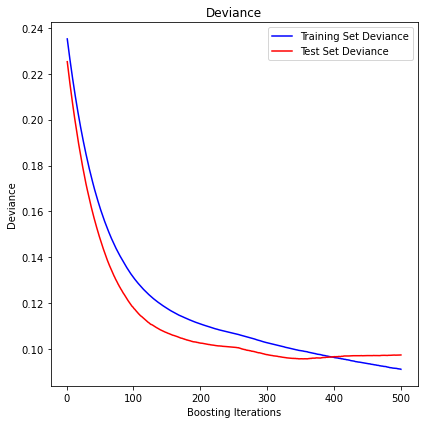

In [337]:
test_score = np.zeros((params["n_estimators"],), dtype=np.float64)
for i, y_pred in enumerate(reg.staged_predict(X_test)):
    test_score[i] = reg.loss_(y_test, y_pred)

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title("Deviance")
plt.plot(
    np.arange(params["n_estimators"]) + 1,
    reg.train_score_,
    "b-",
    label="Training Set Deviance",
)
plt.plot(
    np.arange(params["n_estimators"]) + 1, test_score, "r-", label="Test Set Deviance"
)
plt.legend(loc="upper right")
plt.xlabel("Boosting Iterations")
plt.ylabel("Deviance")
fig.tight_layout()
plt.show()

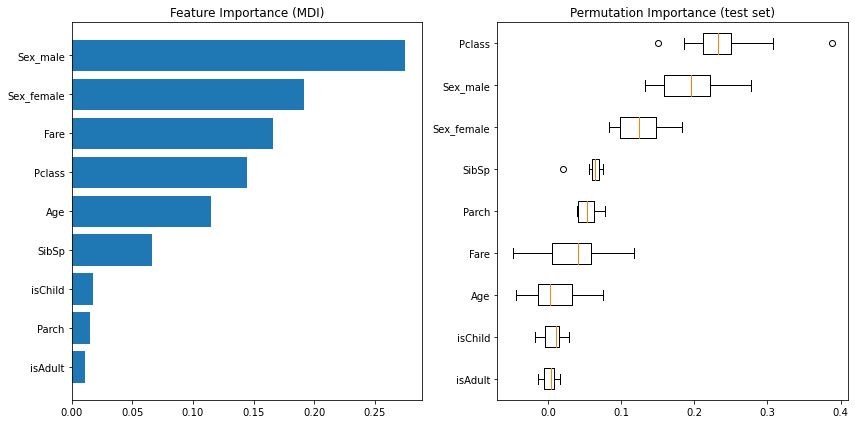

In [338]:
feature_importance = reg.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, np.array(titanic_train_dataframes.columns)[sorted_idx])
plt.title("Feature Importance (MDI)")

result = permutation_importance(
    reg, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(titanic_train_dataframes.columns)[sorted_idx],
)
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()

In [339]:
titanic_test_dataframes = pd.read_csv(test_dataset_directory)

In [340]:
X_train = X
y_train = y

params = {
    "n_estimators": 500,
    "max_depth": 4,
    "min_samples_split": 5,
    "learning_rate": 0.01,
    "loss": "ls"
}

reg = ensemble.GradientBoostingRegressor(**params)
reg.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.01, max_depth=4, min_samples_split=5,
                          n_estimators=500)

In [341]:
titanic_test_dataframes["Age"].fillna(value=average_age, inplace=True)
ages = titanic_test_dataframes["Age"]

titanic_test_dataframes["Fare"].fillna(value=average_fare, inplace=True)

titanic_test_dataframes = one_hot_encode_passenger_sex(one_hot_encoder=one_hot_encoder, titanic_dataframes=titanic_test_dataframes)
titanic_test_dataframes = one_hot_encode_adult_or_child(titanic_dataframes=titanic_test_dataframes, ages=ages)

passenger_ids = titanic_test_dataframes['PassengerId'].values.reshape(-1, 1)

titanic_test_dataframes.drop(['Sex'] ,axis=1, inplace=True)
titanic_test_dataframes.drop(['PassengerId'] ,axis=1, inplace=True)
titanic_test_dataframes.drop(['Name'] ,axis=1, inplace=True)
titanic_test_dataframes.drop(['Embarked'] ,axis=1, inplace=True)
titanic_test_dataframes.drop(['Ticket'] ,axis=1, inplace=True)
titanic_test_dataframes.drop(['Cabin'] ,axis=1, inplace=True)

print(average_age)
print(average_age)
print(titanic_test_dataframes)

predictions = reg.predict(titanic_test_dataframes)
rounded_predictions = [round(value) for value in predictions]

passenger_ids = pd.DataFrame(passenger_ids, columns=["PassengerId"])
rounded_predictions = pd.DataFrame(rounded_predictions, columns=["Survived"])

submission = pd.concat([passenger_ids, rounded_predictions ], axis=1)
print(passenger_ids)
print(rounded_predictions)
print(submission)

submission.to_csv("./result/submission_test.csv", index=False)

23.79929292929293
23.79929292929293
     Pclass        Age  SibSp  Parch        Fare  Sex_female  Sex_male  \
0         3  34.500000      0      0    7.829200         0.0       1.0   
1         3  47.000000      1      0    7.000000         1.0       0.0   
2         2  62.000000      0      0    9.687500         0.0       1.0   
3         3  27.000000      0      0    8.662500         0.0       1.0   
4         3  22.000000      1      1   12.287500         1.0       0.0   
5         3  14.000000      0      0    9.225000         0.0       1.0   
6         3  30.000000      0      0    7.629200         1.0       0.0   
7         2  26.000000      1      1   29.000000         0.0       1.0   
8         3  18.000000      0      0    7.229200         1.0       0.0   
9         3  21.000000      2      0   24.150000         0.0       1.0   
10        3  23.799293      0      0    7.895800         0.0       1.0   
11        1  46.000000      0      0   26.000000         0.0       1.0   
12